In [1]:
from brian2 import *
# set_device('cpp_standalone', directory='network_STDP', clean=True) # for C speedup

In [35]:
'''
Spike-timing dependent plasticity.
Adapted from Song, Miller and Abbott (2000) and Song and Abbott (2001).

This example is modified from ``synapses_STDP.py`` and writes a standalone
C++ project in the directory ``STDP_standalone``.
'''
start_scope()

Npois = 2000    # Number of poisson group neurons
F = 12*Hz    # Poisson stim frequency

Nexcit = 100    # Number of excitatory neurons
Ninhib = 50 #Nexcit//2    # Number of inhibitory neurons
taui = taue = 5*ms    # Excitatory and inhibitory time decay

taum = 10*ms    # Neuron voltage time constant
refrac = 0*ms    # Refractory period
Ee = 0*mV    # Excitatory voltage
Ei = -70*mV    # Inhibitory voltage
Er = -74*mV    # Resting potential
vt = -54*mV    # Threshold value
vr = -60*mV    # Reset voltage


taupre = taupost = 20*ms    # STDP time contant
gmax = .01    # Maximum synaptic strength
dApre = .01 
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

run_length = 1    # Run time in seconds

eqs_neurons = '''
dv/dt = (ge * (Ee-vr) + gi * (Ei-vr) + Er - v) / taum : volt (unless refractory)
dge/dt = -ge / taue : 1
dgi/dt = -gi / taui : 1
'''

### Declare neurons ###
delta_t = .1*second
times_a = np.arange(0, run_length, .1)*second
times_b = times_a + delta_t

stim_neuron_a = SpikeGeneratorGroup(1, [0]*len(times_a), times_a)

stimmer_neuron_b = SpikeGeneratorGroup(1, [0]*len(times_b), times_b)

background = PoissonGroup(Npois, rates = F)

neurons = NeuronGroup(Nexcit+Ninhib, eqs_neurons, threshold='v>vt', reset='v=vr',
                      refractory=refrac, method='exact')

neuron_b = neurons[Ninhib+Nexcit-1]
excit = neurons[:Nexcit]
inhib = neurons[Nexcit:(Nexcit+Ninhib-1)]

### Connect neurons ###
con_stimmer_b_b = Synapses(stimmer_neuron_b, neuron_b,
                  '''w = 1 : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre''',
             on_post='''Apost += dApost''')
con_stimmer_b_b.connect()

con_stim_a_all = Synapses(stim_neuron_a, neurons[:(Nexcit+Ninhib-1)],
                  '''w = 1 : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre''',
             on_post='''Apost += dApost''')
con_stim_a_all.connect(p=.1)

con_background_all = Synapses(background, neurons,
                  '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''')
con_background_all.connect(p=.5)

con_excit_all = Synapses(excit, neurons,
                '''w : 1
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)''',
             on_pre='''ge += w
                    Apre += dApre
                    w = clip(w + Apost, 0, gmax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, gmax)''')
con_excit_all.connect(p=.2)

con_inhib_all = Synapses(inhib, neurons,
                   '''w : 1''',
              on_pre = '''gi +=w ''')
con_inhib_all.connect(p=.2)

con_background_all.w = 'rand() * gmax'
con_excit_all.w = 'rand() * gmax'
con_inhib_all.w = 'rand() * gmax'
neurons.v = 'rand() * Er'

# w_mon_toB = StateMonitor(con_nn, 'w', record = range(Nexcit))
sp_mon_excit = SpikeMonitor(excit)
sp_mon_inhib = SpikeMonitor(inhib)
sp_mon_a = SpikeMonitor(stim_neuron_a)
sp_mon_b = SpikeMonitor(neuron_b)

In [36]:
# Simulation running block
run(run_length*second, report='text')

Starting simulation at t=0. s for a duration of 1. s
1.0 (100%) simulated in 7s


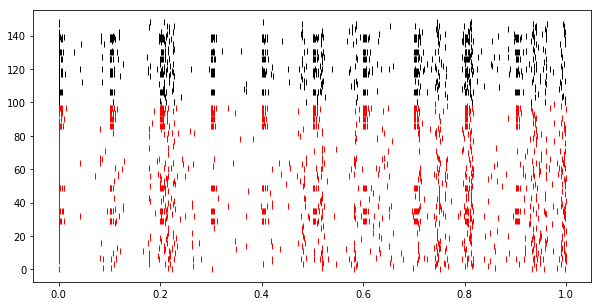

In [38]:
plt.figure(figsize=(10, 5))
# plot(sp_mon_a.t/second, sp_mon_a.i+1, '|g')
# plot(sp_mon_b.t/second, sp_mon_b.i+2, '|r')
plot(sp_mon_excit.t/second, sp_mon_excit.i, '|r')
plot(sp_mon_inhib.t/second, sp_mon_inhib.i+Nexcit, '|k')